In [1]:
!ls

Nome.ipynb   Nome.json    Nome1s.jpg   Nome2s.jpg   Nome_map.jpg matches.jpg


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
print('opnecv version is', cv2.__version__)

opnecv version is 3.1.0


In [3]:
import json
with open("./Nome.json") as f:
    vect = json.load(f)

def filter_points(points, w, h):
    length = int(len(points) / 2)
    pts = []
    badp = False
    for j in range(length):
        if 0 < points[2 * j] and points[2 * j] < w and \
           0 < points[2 * j + 1] and points[2 * j + 1] < h:
            pts.append((points[2 * j], points[2 * j + 1]))
        else:
            badp = True
    return pts, badp
    
    
def draw_vector_image(img):
    fig = plt.figure(figsize=(img["width"]/100, img["height"]/100), dpi=100)
    ax = fig.add_subplot(111)
    fig.subplots_adjust(0,0,1,1)
    ax.set_ylim((0, img["height"]))
    ax.set_xlim((0, img["width"]))
    ax.invert_yaxis()
    ax.axis('off')
    
    for i in range(img["items_count"]):
        if img[str(i)]["tag"] in "water":
            color = "blue"
        else:
            color = "green"
        points, _ = filter_points(img[str(i)]["points"], img["width"], img["height"])
        ax.plot([p[0] for p in points], [p[1] for p in points],
                     color=color, scalex=False, scaley=False)
        
    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()
    
    img = np.fromstring(fig.canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    print(img.shape)
    return img

/Users/Oskar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(936, 1920, 3)


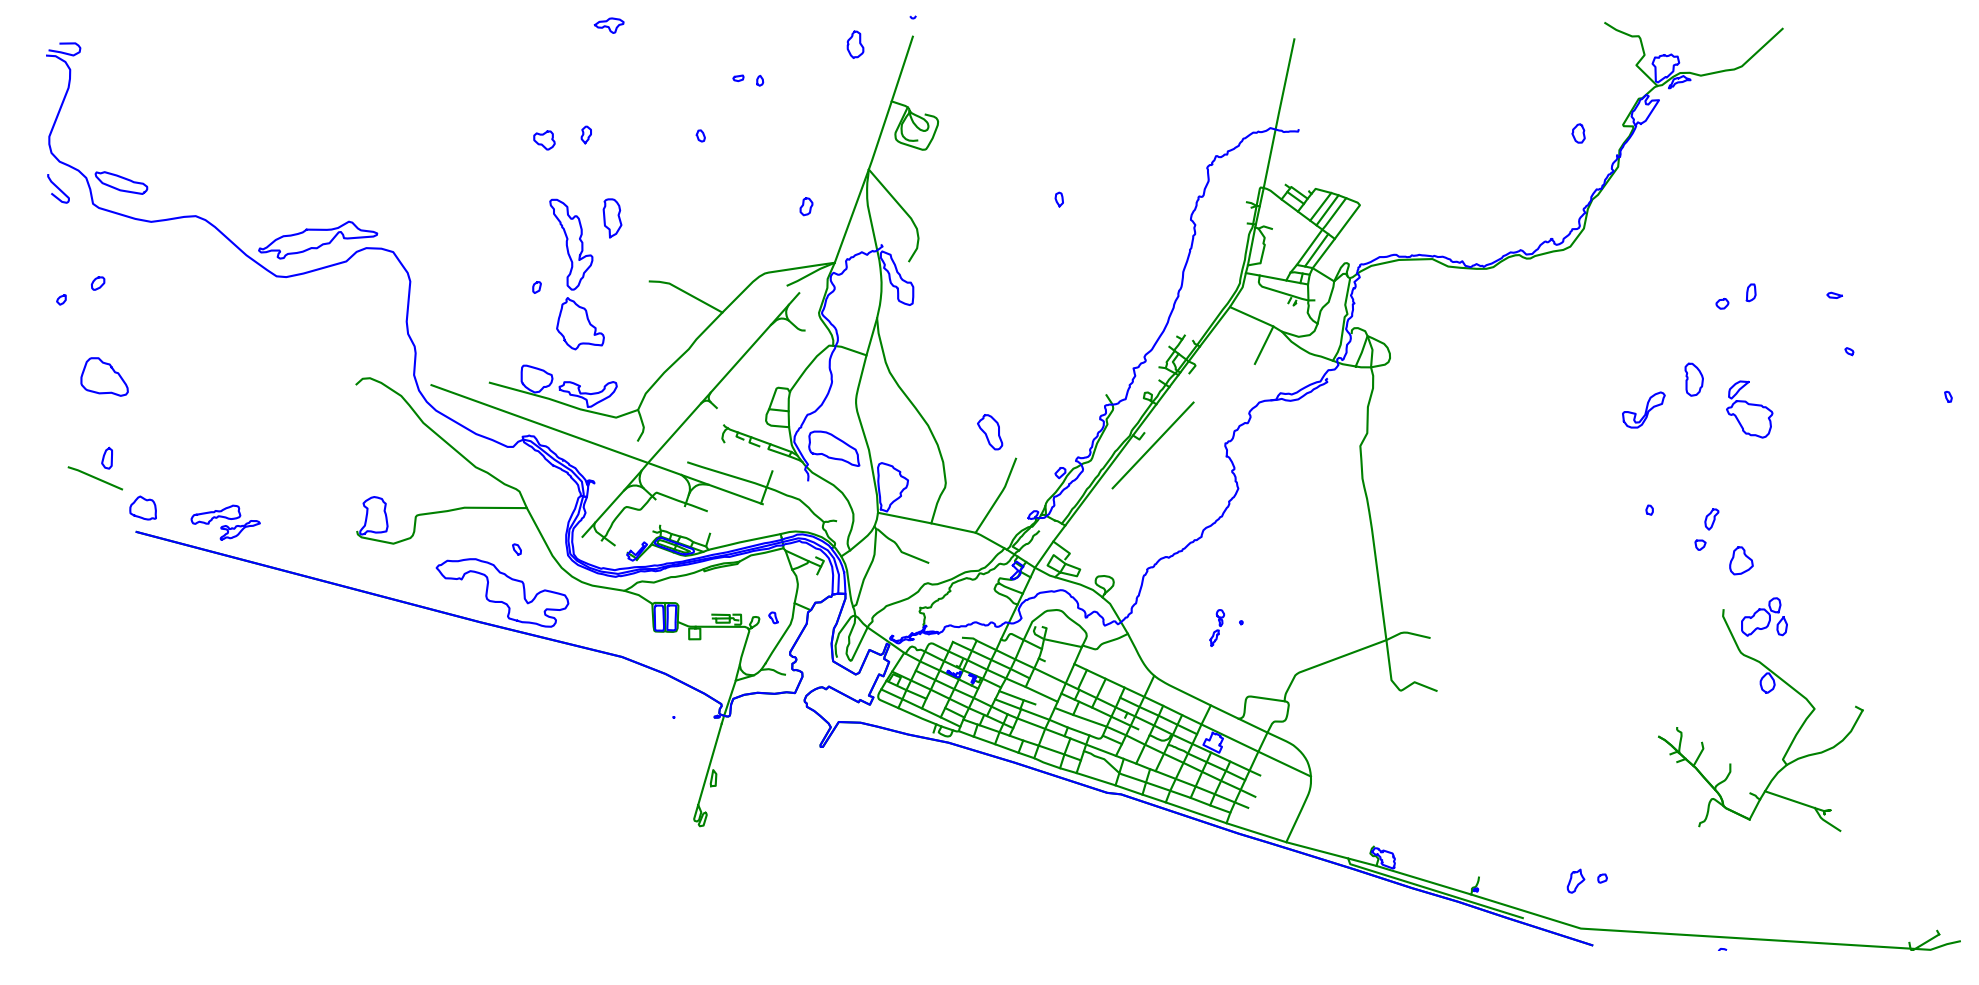

In [4]:
vimg = draw_vector_image(vect)

In [5]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15    

def find_matches(im1, im2):
    orb = cv2.ORB_create(MAX_FEATURES)
    kp1, d1 = orb.detectAndCompute(im1, None)
    kp2, d2 = orb.detectAndCompute(im2, None)

    matcher = cv2.DescriptorMatcher_create("BruteForce-Hamming")
    matches = matcher.match(d1, d2, None)
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    return matches, kp1, d1, kp2, d2

def find_best_scale(im1, im2):
    h,w,_ = im1.shape
    best_score = 9999999999999
    best_i = 0
    for i in range(1, 10, 1):
        matches, kp1, d1, kp2, d2 = find_matches(cv2.resize(im1,(int(w/i),int(h/i))), im2)
        matches.sort(key=lambda x: x.distance, reverse=False)
        
        score = sum([x.distance for x in matches])
        if score < best_score:
            best_score = score
            best_i = i
    print("best scale: ", best_i)
    return  best_i
    
    
def findHomography(im1, im2):
    h, w ,_ = im1.shape
#     scale = find_best_scale(im1, im2)
    scale = 9
    im1resized = cv2.resize(im1,(int(w/scale),int(h/scale)))
    matches, kp1, d1, kp2, d2 = find_matches(im1resized, im2)
    
    # Draw top matches
    imMatches = cv2.drawMatches(im1resized, kp1, im2, kp2, matches, None)
#     cv2.imwrite("matches.jpg", imMatches)
#     fig = plt.figure(figsize=(10, 7), dpi=100)
#     ax = fig.add_subplot(111)
#     fig.subplots_adjust(0,0,1,1)
#     ax.imshow(imMatches)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

    return h, scale
 

In [58]:
def draw_aligned(image, sub_image, homography):
    height, width, _ = image.shape
    imAligned = cv2.warpPerspective(sub_image, homography, (width, height))
    fig = plt.figure(figsize=(10, 7), dpi=100)
    fig.subplots_adjust(0,0,1,1)
    ax = fig.add_subplot(111)
    ax.imshow(imAligned)

def get_square(red_frame, return_as_points = False):
    points = []
    for v in red_frame:
        points.append((v[0][0], v[1][0]))
    points = points[:-1]
    left_border = sorted(points,key=lambda x: x[0], reverse=True)[-2][0]
    right_border = sorted(points,key=lambda x: x[0])[-2][0]
    top_border = sorted(points,key=lambda x: x[1], reverse=True)[-2][1]
    bot_border = sorted(points,key=lambda x: x[1])[-2][1]
    
#     left_border = sorted(points,key=lambda x: x[0], reverse=True)[-1][0]
#     right_border = sorted(points,key=lambda x: x[0])[-1][0]
#     top_border = sorted(points,key=lambda x: x[1], reverse=True)[-1][1]
#     bot_border = sorted(points,key=lambda x: x[1])[-1][1]
    
    offset = (red_frame[0][0][0] - left_border, red_frame[0][1][0] - top_border)
    
    if return_as_points:
        return [(left_border, bot_border), (left_border, top_border), (right_border, top_border), (right_border,bot_border), (left_border, bot_border)]
    return [left_border, right_border, top_border, bot_border], offset
    
    
def draw_frame(image, sub_image, homography):
    height, width, _ = sub_image.shape
    red_frame = np.array([[[0],[0],[1]],[[0],[height],[1]], [[width], [height],[1]], [[width], [0],[1]],[[0],[0],[1]]])
    red_frame = homography @ red_frame
    red_frame_norm = []
    for rf in red_frame:
        red_frame_norm.append(rf / rf[2][0])
    red_frame = np.array(red_frame_norm)
    
    fig = plt.figure(figsize=(10, 7), dpi=100)
    fig.subplots_adjust(0,0,1,1)
    ax = fig.add_subplot(111)
    ax.imshow(image)
    ax.plot([p[0][0] for p in red_frame], [p[1][0] for p in red_frame],
                     color="red", scalex=True, scaley=True)
    
    sq = get_square(red_frame, True)
    ax.plot([s[0] for s in sq], [s[1] for s in sq],
                     color="blue", scalex=True, scaley=True)
    
    return red_frame
    
def draw_overlay(vimage, sub_image, homography):
    height, width, _ = vimage.shape
    imAligned = cv2.warpPerspective(sub_image, homography, (width, height))
    
    
    #make bg transparent
    tmp = cv2.cvtColor(imAligned, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(imAligned)
    rgba = [b,g,r, alpha]
    imAligned = cv2.merge(rgba,4)
    
    fig = plt.figure(figsize=(10, 7), dpi=100)
    fig.subplots_adjust(0,0,1,1)
    ax = fig.add_subplot(111)
    ax.imshow(vimage)    
    ax.imshow(imAligned, alpha=0.7)
    return imAligned
    
def crop_image(img, square):
#   square = [left_border, right_border, top_border, bot_border]
    y = int(square[2])
    h = int(square[3] - square[2])
    x = int(square[0])
    w = int(square[1] - square[0])
    crop_img = img[y:y+h, x:x+w].copy()
    return crop_img

In [77]:
def find_position(template, vimg, matching_method):
    h, w, _ = template.shape
    gray1 = cv2.cvtColor(vimg, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    res = cv2.matchTemplate(gray1, gray2, matching_method )
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(min_val, max_val, min_loc, max_loc)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(vimg, top_left, bottom_right, 0, 5)

    fig = plt.figure(figsize=(12, 8), dpi=100)
#     fig.suptitle("Template search", fontsize=16, y=-1)
#     fig.subplots_adjust(0,0,1,1)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title('Template search')
    ax2.set_title('Found position')
    ax1.imshow(res)   
    ax2.imshow(vimg)    
    return top_left, bottom_right
    

In [84]:
def match_images(image_f, sub_image_f, image_offset=None, matching_method=cv2.TM_CCORR_NORMED):
    print("Reading map image : ", image_f)
    image = cv2.imread(image_f, cv2.IMREAD_COLOR)
    print("Reading sub image : ", sub_image_f);  
    sub_image = cv2.imread(sub_image_f, cv2.IMREAD_COLOR)
    print("Aligning images ...")

    homography, scale = findHomography(sub_image, image)
    print("Estimated homography : \n",  homography)
    
    height, width, _ = sub_image.shape
    sub_image = cv2.resize(sub_image,(int(width/scale),int(height/scale)))
    
#     draw_aligned(image, sub_image, homography)
    red_frame = draw_frame(image, sub_image, homography)
    imAligned = draw_overlay(vimg, sub_image, homography)
    square, frame_offset = get_square(red_frame)
    
    # matching with vector image
    if image_offset is None:
        template = crop_image(imAligned, square)
        frame_top_left = red_frame[0]
        top_left, bottom_right = find_position(template, vimg.copy(), matching_method)
        desired_position = (frame_offset[0] + top_left[0], frame_offset[1] + top_left[1])
#         if matching_method==cv2.TM_CCORR_NORMED:
#             desired_position = (top_left[0], top_left[1])
        image_offset = (desired_position[0] - frame_top_left[0][0], desired_position[1] - frame_top_left[1][0])
    #     image_offset = (frame_top_left[0][0] - desired_position[0], frame_top_left[1][0] - desired_position[1])
    
    height, width, _ = imAligned.shape
    M = np.float32([[1,0,image_offset[0]],[0,1,image_offset[1]]])
    dst = cv2.warpAffine(imAligned,M,(width,height))
    
    fig = plt.figure(figsize=(10, 7), dpi=100)
    fig.suptitle("Applied offset")
    fig.subplots_adjust(0,0,1,1)
    ax = fig.add_subplot(111)
    ax.imshow(vimg)    
    ax.imshow(dst, alpha=0.7)
    
    rf = M @ red_frame
    ax.plot([p[0][0] for p in rf], [p[1][0] for p in rf],
                     color="red", scalex=True, scaley=True)

Reading map image :  Nome_map.jpg
Reading sub image :  Nome1s.jpg
Aligning images ...
Estimated homography : 
 [[ 9.78056391e-01  5.69302875e-01  6.23572817e+02]
 [-1.63625591e-02  1.46987615e+00  5.10414785e+02]
 [-2.12638509e-05  6.33433641e-04  1.00000000e+00]]
0.8575828671455383 0.9303221106529236 (604, 412) (3, 602)


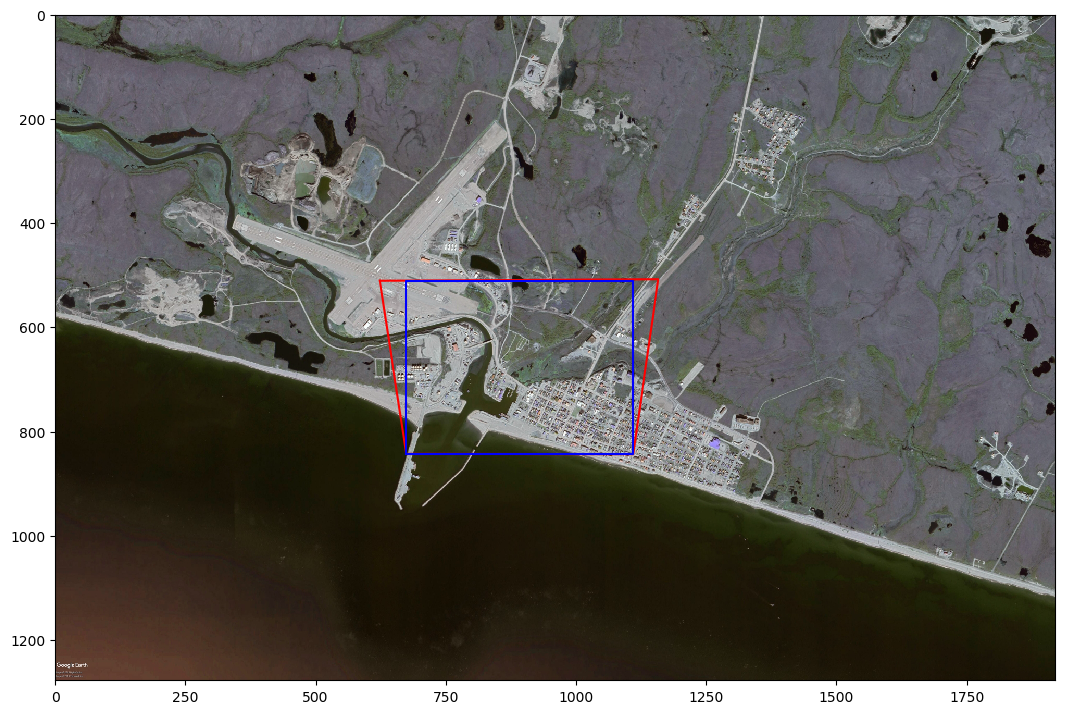

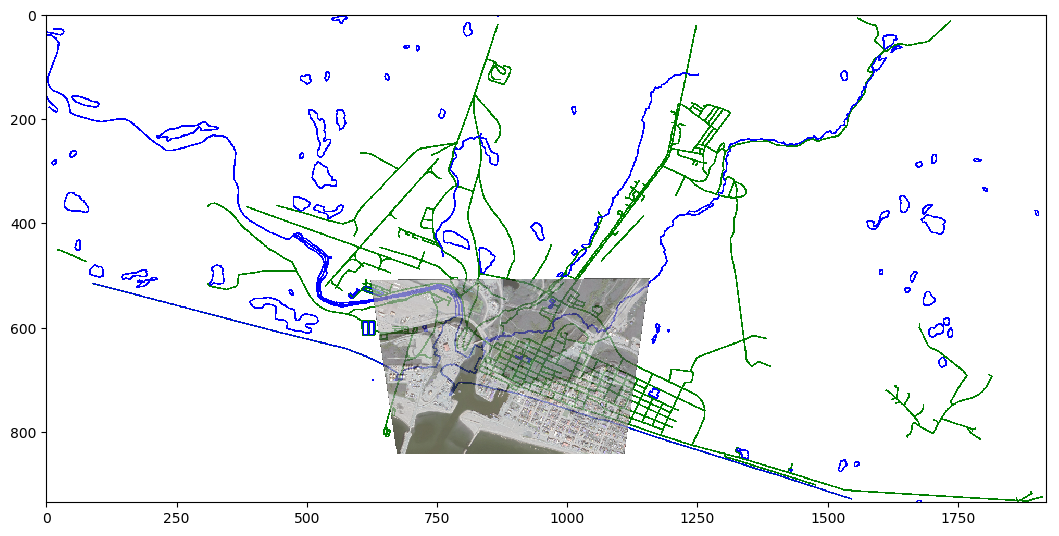

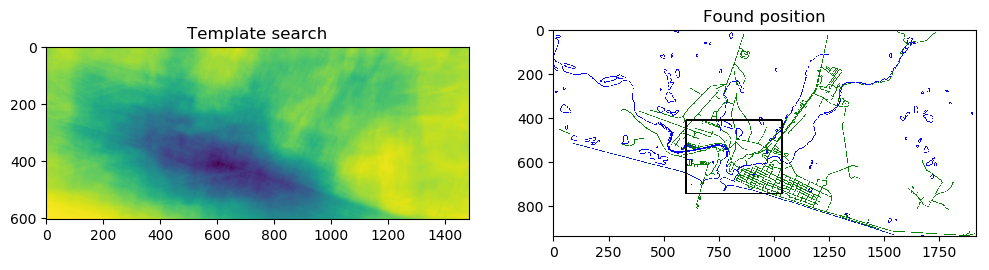

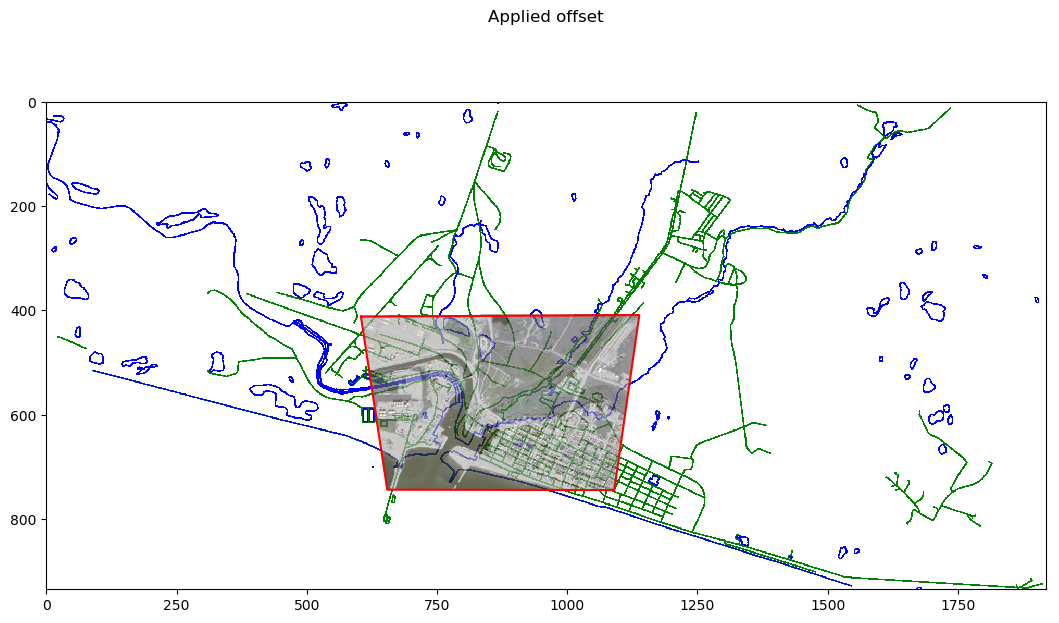

In [85]:
match_images("Nome_map.jpg", "Nome1s.jpg", matching_method=cv2.TM_CCORR_NORMED)

Reading map image :  Nome_map.jpg
Reading sub image :  Nome2s.jpg
Aligning images ...
Estimated homography : 
 [[ 1.09791711e+00  1.57762836e+00  9.37210689e+02]
 [-3.56355198e-01  1.93956587e+00  6.92201103e+02]
 [-1.63777222e-05  9.37177759e-04  1.00000000e+00]]
-55663156.0 38835368.0 (1009, 590) (799, 674)


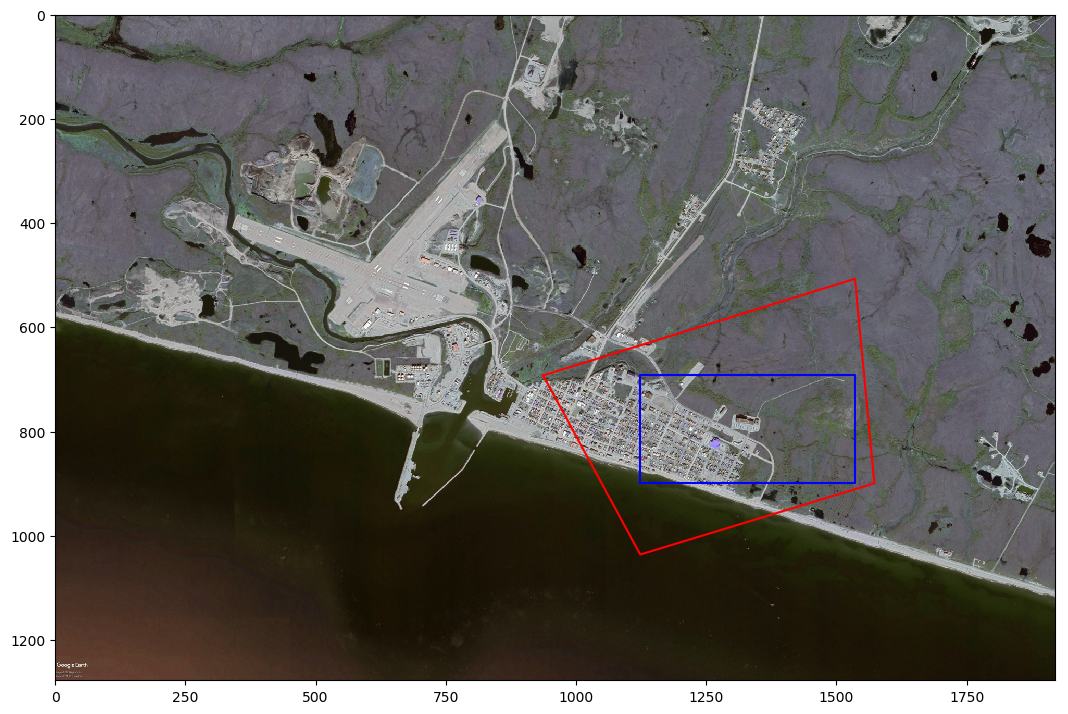

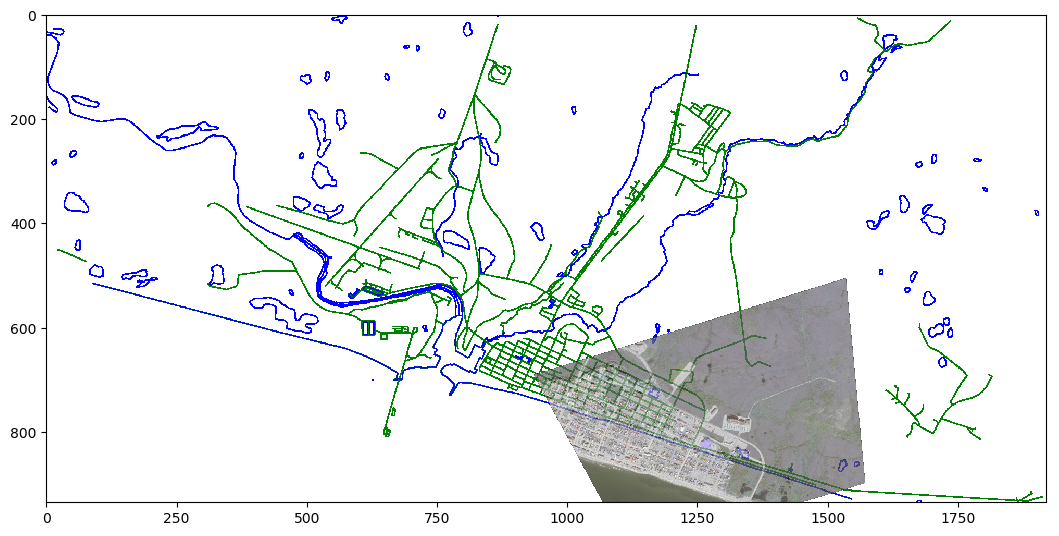

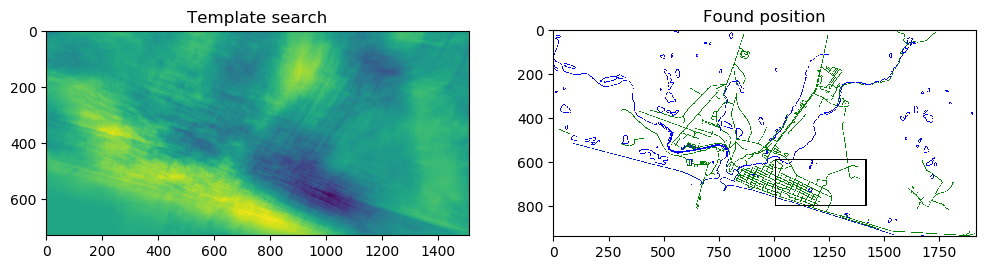

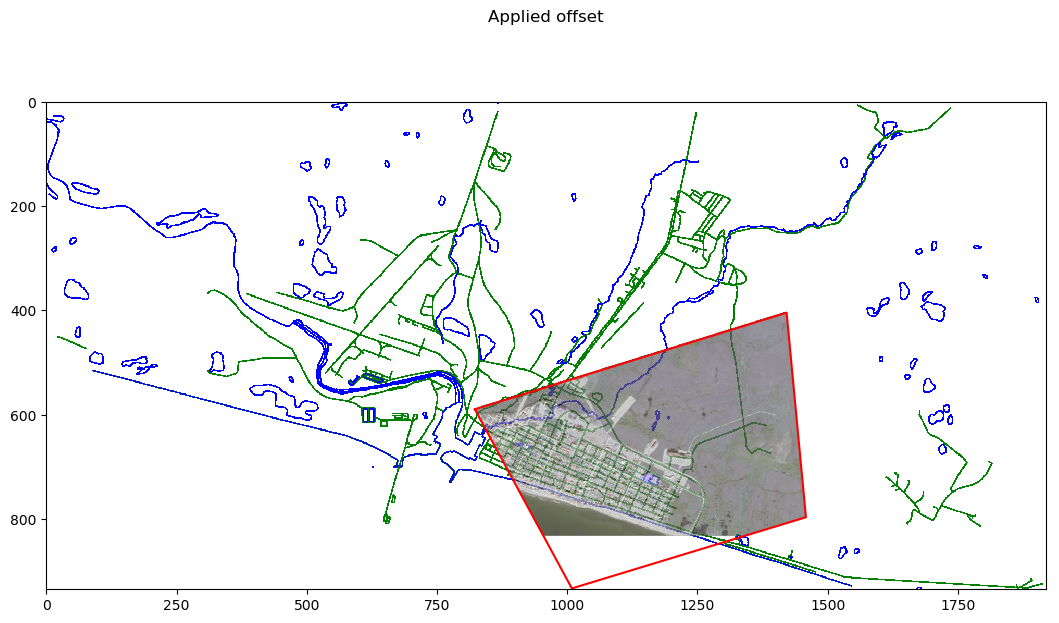

In [83]:
match_images("Nome_map.jpg", "Nome2s.jpg", matching_method=cv2.TM_CCOEFF)